<a href="https://colab.research.google.com/github/hyeonjusong410/DL.Basic/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!cp "/content/drive/MyDrive/Colab Notebooks/DL_Basic/GAN_dataset.zip" /content/
!unzip "/content/GAN_dataset.zip"

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: celebA/img/197610.jpg   
  inflating: celebA/img/197611.jpg   
  inflating: celebA/img/197612.jpg   
  inflating: celebA/img/197613.jpg   
  inflating: celebA/img/197614.jpg   
  inflating: celebA/img/197615.jpg   
  inflating: celebA/img/197616.jpg   
  inflating: celebA/img/197617.jpg   
  inflating: celebA/img/197618.jpg   
  inflating: celebA/img/197619.jpg   
  inflating: celebA/img/197620.jpg   
  inflating: celebA/img/197621.jpg   
  inflating: celebA/img/197622.jpg   
  inflating: celebA/img/197623.jpg   
  inflating: celebA/img/197624.jpg   
  inflating: celebA/img/197625.jpg   
  inflating: celebA/img/197626.jpg   
  inflating: celebA/img/197627.jpg   
  inflating: celebA/img/197628.jpg   
  inflating: celebA/img/197629.jpg   
  inflating: celebA/img/197630.jpg   
  inflating: celebA/img/197631.jpg   
  inflating: celebA/img/197632.jpg   
  inflating: celebA/img/197633.jpg   
  inflating: celebA/img/197634.jpg   
  inflating: c

In [5]:
import random
import torch
import torch.nn as nn
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import os.path as osp

%matplotlib inline

In [6]:
# Data path
PATH = "/content/MNIST/"

# Batch size
bs = 256

# image size
img_size = 28

# latent vector z의 size
z_size = 100

# training epochs
num_epochs = 500

# Learning rate
lr = 0.001

# Beta1 hyperparameter(for Adam)
beta1 = 0.5

# Real or Fake label
real_label = 1
fake_label = 0

### Dataset loading & Data Loader

In [7]:
train_dataset = dset.MNIST(root=PATH,
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

data_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=bs,
                                          shuffle=True,
                                          drop_last=True)

### Generative model G

In [16]:
# Generator's hidden layer size (Channels of generator feature) : 128
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.g_fc1 = nn.Linear(z_size, 128)
        self.g_relu = nn.ReLU()
        self.g_fc2 = nn.Linear(128, 784)
        self.g_sigmoid = nn.Sigmoid()
        # Initialize weight parameters
        nn.init.xavier_uniform_(self.g_fc1.weight, gain=nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.g_fc2.weight, gain=nn.init.calculate_gain('sigmoid'))

    def forward(self, x):
        x = self.g_relu(self.g_fc1(x))
        x = self.g_sigmoid(self.g_fc2(x))
        x = x.view(-1, 1, 28, 28)

        return x

### Discriminative model D

In [25]:
# Discriminator's hidden layer size (Channels of discriminator feature) : 128
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.d_fc1 = nn.Linear(784, 128)
        self.d_relu = nn.ReLU()
        self.d_fc2 = nn.Linear(128, 1)
        self.d_sigmoid = nn.Sigmoid()
        # Initialize weight parameters
        nn.init.xavier_uniform_(self.d_fc1.weight, gain=nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.d_fc2.weight, gain=nn.init.calculate_gain('sigmoid'))

    def forward(self, x):
        x = x.view(x.size(0), -1) # Flatten the input tensor
        x = self.d_relu(self.d_fc1(x))
        x = self.d_sigmoid(self.d_fc2(x))
        return x

In [26]:
model_G = Generator()
model_D = Discriminator()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_G.to(device)
model_D.to(device)
print(model_G)
print(model_D)

Generator(
  (g_fc1): Linear(in_features=100, out_features=128, bias=True)
  (g_relu): ReLU()
  (g_fc2): Linear(in_features=128, out_features=784, bias=True)
  (g_sigmoid): Sigmoid()
)
Discriminator(
  (d_fc1): Linear(in_features=784, out_features=128, bias=True)
  (d_relu): ReLU()
  (d_fc2): Linear(in_features=128, out_features=1, bias=True)
  (d_sigmoid): Sigmoid()
)


### Loss function & optimizer(Adam)

In [27]:
criterion = nn.BCELoss()

optimizer_G = torch.optim.Adam(model_G.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = torch.optim.Adam(model_D.parameters(), lr=lr, betas=(beta1, 0.999))

### function for visualizing picture

In [28]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)
    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')
    return fig

### Traininig GAN

[10/500][234/234]	Loss_D: 0.2550	Loss_G: 2.3179
[20/500][234/234]	Loss_D: 0.5423	Loss_G: 3.1504
[30/500][234/234]	Loss_D: 0.3638	Loss_G: 2.3867
[40/500][234/234]	Loss_D: 0.0119	Loss_G: 5.5792
[50/500][234/234]	Loss_D: 0.0006	Loss_G: 9.4695
[60/500][234/234]	Loss_D: 0.6007	Loss_G: 1.9341
[70/500][234/234]	Loss_D: 0.4132	Loss_G: 1.7311
[80/500][234/234]	Loss_D: 0.4194	Loss_G: 2.2104
[90/500][234/234]	Loss_D: 0.4263	Loss_G: 1.7422
[100/500][234/234]	Loss_D: 0.4507	Loss_G: 1.9474
[110/500][234/234]	Loss_D: 0.5037	Loss_G: 1.5001
[120/500][234/234]	Loss_D: 0.4415	Loss_G: 1.6401
[130/500][234/234]	Loss_D: 0.4280	Loss_G: 1.4766
[140/500][234/234]	Loss_D: 0.3996	Loss_G: 1.9324
[150/500][234/234]	Loss_D: 0.4170	Loss_G: 1.6952
[160/500][234/234]	Loss_D: 0.4979	Loss_G: 1.4101
[170/500][234/234]	Loss_D: 0.4081	Loss_G: 1.7892
[180/500][234/234]	Loss_D: 0.3594	Loss_G: 2.8738
[190/500][234/234]	Loss_D: 0.4080	Loss_G: 2.5993
[200/500][234/234]	Loss_D: 0.3931	Loss_G: 2.5367
[210/500][234/234]	Loss_D: 0.

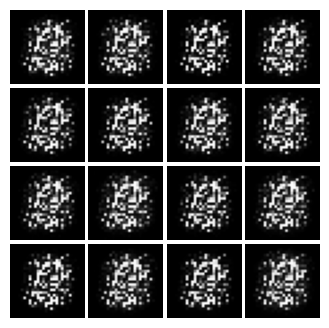

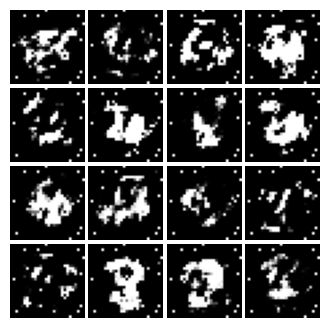

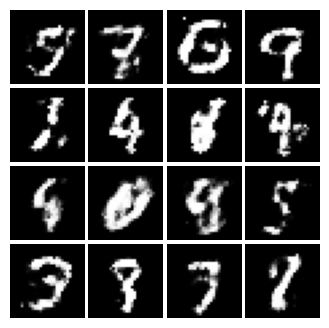

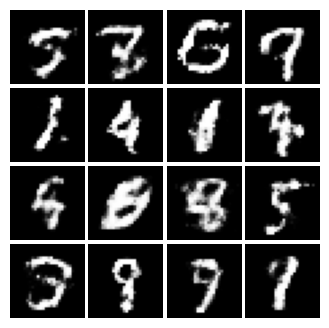

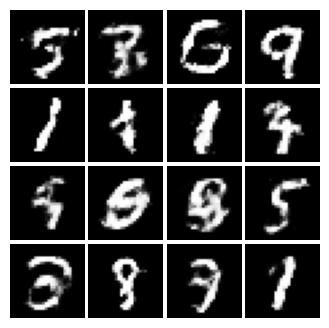

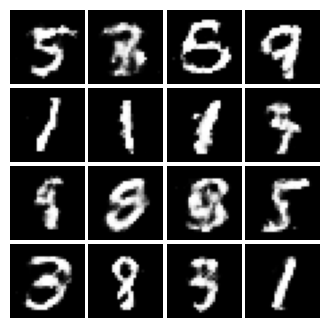

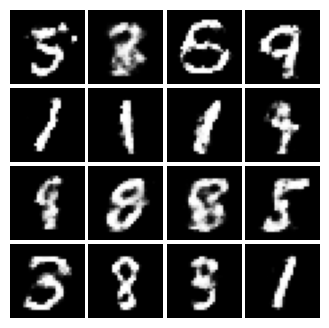

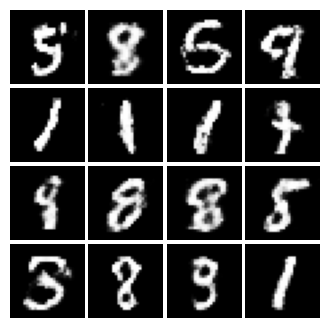

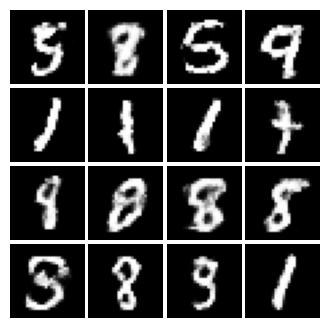

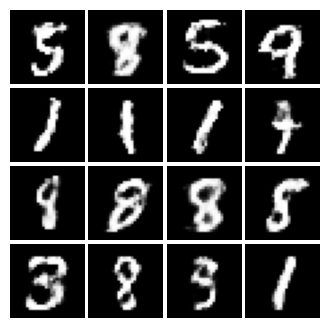

In [30]:
# label for real & fake data
label_real = torch.full((bs,), real_label, device=device, dtype=torch.float)
label_fake = torch.full((bs,), fake_label, device=device, dtype=torch.float)

#  Noise
fixed_noise = torch.randn(bs, z_size, device=device, dtype=torch.float)

for epoch in range(num_epochs):

    model_G.train()
    model_D.train()

    for i, data in enumerate(data_loader):

        data = data[0].to(device)
        data = data.view(bs, -1)

        # Discriminator--------------------------------
        # Initialize grad
        optimizer_G.zero_grad()
        optimizer_D.zero_grad()

        # Making fake img
        z = torch.randn(bs, z_size).to(device)
        fake_img = model_G(z)

        # Loss Function
        fake_loss = criterion(model_D(fake_img), label_fake.unsqueeze(1))
        real_loss = criterion(model_D(data), label_real.unsqueeze(1))
        err_D = (fake_loss + real_loss) / 2

        # backpropagation
        err_D.backward()
        optimizer_D.step()

        # Generator-----------------------------------
        # Initialize grad
        optimizer_G.zero_grad()
        optimizer_D.zero_grad()

        # Making fake img
        z = torch.randn(bs, z_size).to(device)
        fake_img = model_G(z)

        # Loss Function
        err_G = criterion(model_D(fake_img), label_real.unsqueeze(1))

        # backpropagation
        err_G.backward()
        optimizer_G.step()




    # Output training stats
    if (epoch+1) % 10 == 0:
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
              % ((epoch+1), num_epochs, i+1, len(data_loader), err_D.item(), err_G.item()))

    if (epoch) % 50 == 0:
        model_G.eval()
        model_D.eval()
        output = model_G(fixed_noise).detach().cpu().numpy()
        fig = plot(output[:16])